Tamanna Ananna <br />
ta2642

In [ ]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits import mplot3d
from numpy.random import uniform


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault
import tensorflow as tf
import keras
from keras import initializers
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout 
from keras.layers import LeakyReLU, Flatten, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard


from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.image import grayscale_to_rgb
from tensorflow import expand_dims


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import time

from keras import backend as K




Co-adaptation:

Co-adaption refers to when some neural networks become highly dependent on each other. So if one of them receive bad or noisy input, the impact of the bad input spreads to the dependent networks as well. This leads to over-fitting. Drop out is a way of dealing with co-adaption, where randomly units are dropped during training, preventing them from being reliant and dependent on each other. So they learn the feature more and perform better on unseen data. 


Internal covariance shift:

Internal covariance shift refers to the phenomenon where ws the parameter of previous layers change, the distribution of each layer's input also change during training. To counteract, lower learning rates are necessary but that slows down training. Additionally, parameter initialization becomes very important, and overall makes training models difficult.  
batch normalization is a way deal with this problem where each mini-batch are normalized, allowing higher training rate and less dependence on initialization. 



In [3]:
# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))


#mnist data are 28*28 pixels
#pad each image with 0s to turn to 32*32 pixel images
x_train = np.pad(x_train, [(0,0), (0,4),(0,4)], 'constant')
x_test = np.pad(x_test, [(0,0), (0,4),(0,4)], 'constant')
print(x_train.shape)

dim = 32*32
#reshape to 4-dims so it works with Keras and convert to float to normalize
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1).astype('float32')

print(x_train.shape)
print(x_test.shape)

#divide by 255 to get pixel between 0 and 1
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_valid = x_train[:5000]
y_valid = y_train[:5000]



11501568/11490434 [==============================] - 0s 0us/step
(60000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [4]:
x_train.shape

(60000, 32, 32, 1)

# LeNet-5 Model

LeNet-5 layers:
1. Convolution #1. Input = 32x32x1. Output = 28x28x6 conv2d
2. SubSampling #1. Input = 28x28x6. Output = 14x14x6. SubSampling is simply Average Pooling so we use avg_pool
3. Convolution #2. Input = 14x14x6. Output = 10x10x16 conv2d
4. SubSampling #2. Input = 10x10x16. Output = 5x5x16 avg_pool
5. Fully Connected #1. Input = 5x5x16. Output = 120
6. Fully Connected #2. Input = 120. Output = 84
7. Softmax with Output 10

## Standard norm for input and batch for hidden

In [43]:
def build_lenet5_standard():
  model = Sequential()
  model.add(Conv2D(filters=6, kernel_size=(3, 3), input_shape=(32,32,1)))
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())

  #flattens output of final pooling layer for the fully connected layer
  model.add(Flatten())
  model.add(Dense(units=120))
  model.add(Activation('tanh'))

  model.add(Dense(units=84))
  model.add(Activation('tanh'))

  #output
  model.add(Dense(units=10))
  model.add(Activation('softmax'))
  return model


def compile_model(model):
  model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
  return model

def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


# Standard LeNet-5 with no batch normalization

In [61]:
standard = build_lenet5_standard()

standard = compile_model(standard) #compile model

history = standard.fit(x_train, y_train, batch_size = 128, verbose= 0)

train_loss = history.history['loss']
train_acc = history.history['accuracy']

test_loss, test_acc = standard.evaluate(x_test, y_test, verbose= 0)
print('Train loss %.3f' %train_loss[0])
print('Test loss %.3f' %test_loss)
print('Train accuracy %.3f percent'  %(train_acc[0]*100))
print('Test accuracy %.3f percent'  %(test_acc*100))

Train loss 0.343
Test loss 0.175
Train accuracy 90.217 percent
Test accuracy 94.720 percent


## Lenet-5 with BatchNormalization between layers


In [62]:
def build_lenet5_batchnorm():
  model = Sequential()
  model.add(Conv2D(filters=6, kernel_size=(3, 3), input_shape=(32,32,1)))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())

  #flattens output of final pooling layer for the fully connected layer
  model.add(Flatten())
  model.add(Dense(units=120))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(Dense(units=84))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  #output
  model.add(Dense(units=10))
  model.add(Activation('softmax'))
  return model

In [63]:
batchnorm = build_lenet5_batchnorm() #build model

The learned batch parameters are beta and gamma

In [64]:
batchnorm = compile_model(batchnorm) #compile model

history = batchnorm.fit(x_train, y_train, batch_size = 128, verbose= 0)

In [65]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

test_loss, test_acc = batchnorm.evaluate(x_test, y_test, verbose= 0)
print('Train loss %.3f' %train_loss[0])
print('Test loss %.3f' %test_loss)
print('Train accuracy %.3f percent'  %(train_acc[0]*100))
print('Test accuracy %.3f percent'  %(test_acc*100))

Train loss 0.187
Test loss 0.210
Train accuracy 94.727 percent
Test accuracy 93.780 percent


Batch normalization of hidden layers appears to slightly reduce performance on test

In [66]:
def get_batchlayer_weights(model):
  batch_ind = []
  for i, layer in enumerate(model.layers):
    if(layer.name.startswith('batch')):
      batch_ind.append(i)

  gamma = []
  beta = []
  rows = []

  #for each batch layer, get the learned parameters
  for b_i in batch_ind:
    layer = model.layers[b_i]
    gamma = layer.get_weights()[0]
    beta = layer.get_weights()[1]
    #print(beta)
    for i, b in enumerate(beta):
      rows.append([b_i, gamma[i], beta[i]])
    
  df = pd.DataFrame(rows, columns=['Hidden Layer',  'Gamma', 'Beta'])
  return df

#make violin plots of gamma and beta at each layer
def make_violin_plot(df, xname, yname):
  fig = plt.figure(figsize=(12, 6))
  axes = grid_axes_it(1, 1, fig=fig)

  ax = next(axes)
  sns.violinplot(x=xname, y=yname, data=df, ax=ax, scale='count', inner=None)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title('Learned Norm-'+yname +'', fontsize=13)
  ax.set_ylabel(yname)
  ax.set_xlabel(xname) 
  plt.tight_layout()
  plt.show()


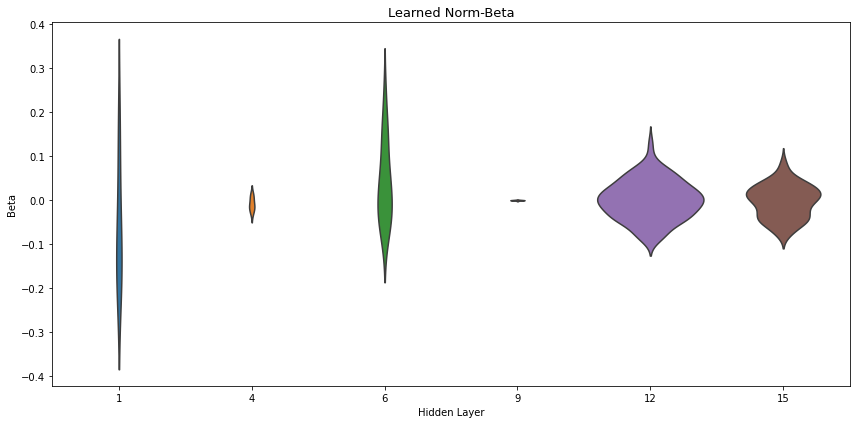

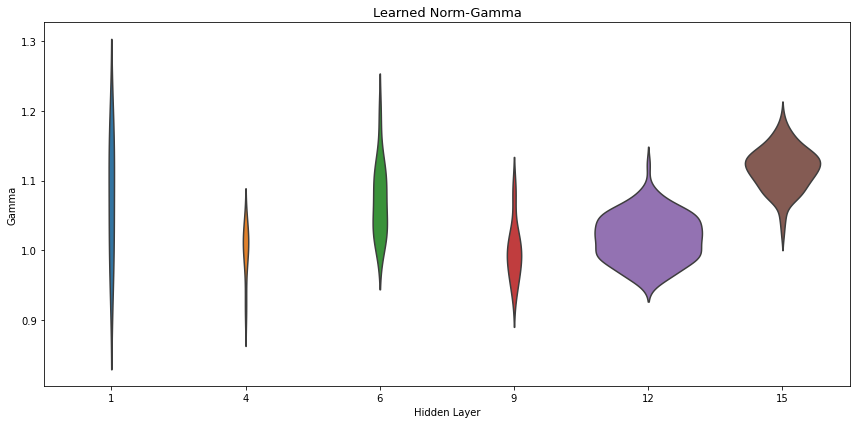

In [67]:
df = get_batchlayer_weights(batchnorm)
make_violin_plot(df, 'Hidden Layer', 'Beta')
make_violin_plot(df, 'Hidden Layer', 'Gamma')

## LeNet-5 with Batch normalization to input layer + hidden layers

In [69]:
def build_lenet5_batchnorm_input():
  model = Sequential()
  model.add(BatchNormalization(input_shape=(32,32,1)))
  model.add(Conv2D(filters=6, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())

  #flattens output of final pooling layer for the fully connected layer
  model.add(Flatten())
  model.add(Dense(units=120))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(Dense(units=84))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  #output
  model.add(Dense(units=10))
  model.add(Activation('softmax'))
  return model

In [74]:
batchnorm_input = build_lenet5_batchnorm_input()
batchnorm_input = compile_model(batchnorm_input)

history = batchnorm_input.fit(x_train, y_train, batch_size = 128, verbose= 0)

train_loss = history.history['loss']
train_acc = history.history['accuracy']

test_loss, test_acc = batchnorm_input.evaluate(x_test, y_test, verbose= 0)

test_loss, test_acc = batchnorm_input.evaluate(x_test, y_test, verbose= 0)
print('Train loss %.3f' %train_loss[0])
print('Test loss %.3f' %test_loss)
print('Train accuracy %.3f percent'  %(train_acc[0]*100))
print('Test accuracy %.3f percent'  %(test_acc*100))

Train loss 0.180
Test loss 0.115
Train accuracy 94.972 percent
Test accuracy 96.440 percent


Batch normalizationg of input layer + hidden layer improved performance on test set over batch normalization of hidden layers only and also over standard with no batch normalization

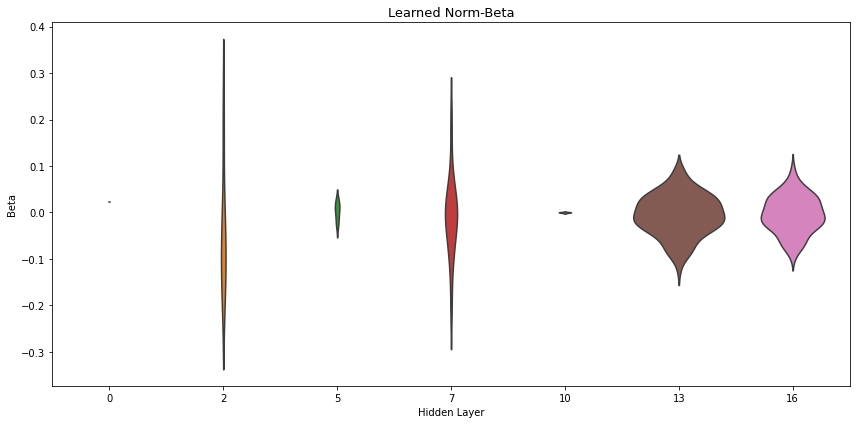

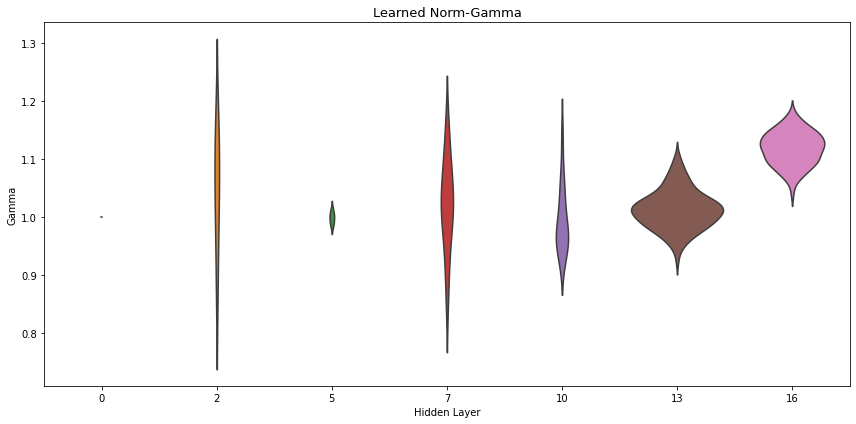

In [75]:
df_bn_input = get_batchlayer_weights(batchnorm_input)
make_violin_plot(df_bn_input, 'Hidden Layer', 'Beta')
make_violin_plot(df_bn_input, 'Hidden Layer', 'Gamma')

## LeNet-5 with dropout only
dropout used for input & after conv and pooling layers

Dropout of 0.2 in input layer.

Dropout of 0.5 for hidden layers.

In [76]:
def build_lenet5_dropout():

  model = Sequential()

  model.add(Dropout(0.2, input_shape=(32,32,1)))
  model.add(Conv2D(filters=6, kernel_size=(3, 3)))

  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(Dropout(0.5))

  #flattens output of final pooling layer for the fully connected layer
  model.add(Flatten())
  model.add(Dense(units=120))
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  model.add(Dense(units=84))
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  #output
  model.add(Dense(units=10))
  model.add(Activation('softmax'))

  return model


In [77]:
dropout = build_lenet5_dropout()
dropout = compile_model(dropout)

history = dropout.fit(x_train, y_train, batch_size = 128, verbose= 0)

train_loss = history.history['loss']
train_acc = history.history['accuracy']

test_loss, test_acc = dropout.evaluate(x_test, y_test, verbose= 0)

print('Train loss %.3f' %train_loss[0])
print('Test loss %.3f' %test_loss)
print('Train accuracy %.3f percent'  %(train_acc[0]*100))
print('Test accuracy %.3f percent'  %(test_acc*100))


Train loss 0.932
Test loss 0.447
Train accuracy 70.018 percent
Test accuracy 89.250 percent


Using dropout only has a test accuracy of 89.25% which is significantly less than the 97% achieved with batch normalization

# LeNet-5 with Batch Norm + Dropout

In [78]:
def build_lenet5_dropout_batchnorm():
  model = Sequential()
  model.add(BatchNormalization(input_shape=(32,32,1)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=6, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  model.add(AveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  #flattens output of final pooling layer for the fully connected layer
  model.add(Flatten())
  model.add(Dense(units=120))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Activation('tanh'))

  model.add(Dense(units=84))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Activation('tanh'))

  #output
  model.add(Dense(units=10))
  model.add(Activation('softmax'))
  return model

In [79]:
combined = build_lenet5_dropout_batchnorm()
combined = compile_model(combined)

history = combined.fit(x_train, y_train, batch_size = 128, verbose= 0)

train_loss = history.history['loss']
train_acc = history.history['accuracy']

test_loss, test_acc = combined.evaluate(x_test, y_test, verbose= 0)

print('Train loss %.3f' %train_loss[0])
print('Test loss %.3f' %test_loss)
print('Train accuracy %.3f percent'  %(train_acc[0]*100))
print('Test accuracy %.3f percent'  %(test_acc*100))

Train loss 1.232
Test loss 0.669
Train accuracy 58.827 percent
Test accuracy 81.870 percent


With both dropout and batch norm, we see the worst accuracy compared to batch norm only or drop out only.

The test accuracy is 81%, 10% lower than drop out only and 20% lower than batch only